/tmp/ipykernel_353921/3194938909.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset[column].fillna(dataset[column].mean(), inplace=True)


Testing k=1...
Testing k=2...
Testing k=3...
Testing k=4...
Testing k=5...
Testing k=6...
Testing k=7...
Testing k=8...
Testing k=9...
Testing k=10...
Best training accuracy: 1.0000 at k=1
Best validation accuracy: 0.8334 at k=5


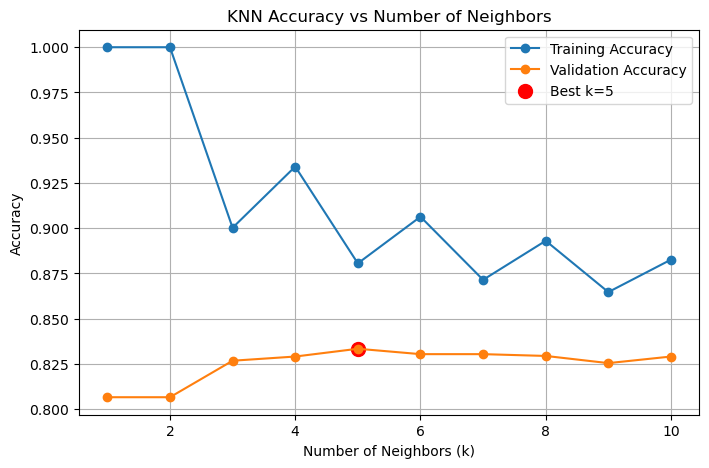

Test accuracy: 0.8344 at k=5

Classification Report:
Precision: 0.8337
Recall: 0.8344
F1 Score: 0.8289


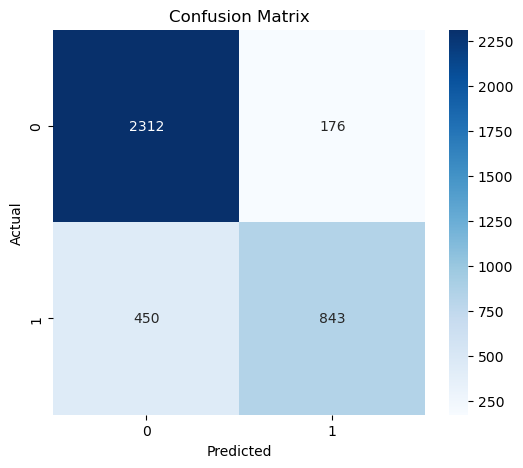

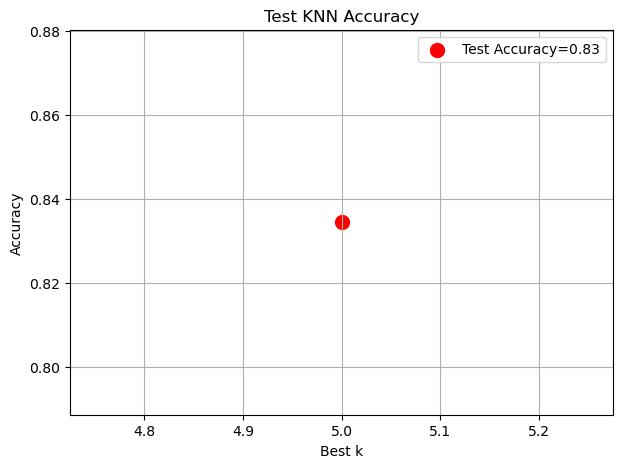

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix  # ⭐ NEW
import seaborn as sns  
from collections import Counter
import json

Ks = range(1,11)
trn_acc = []
val_acc = []
bestk = 0
testAcc = 0.0

def check_duplicates(dataset):
    return dataset.drop_duplicates()

def check_missing_values(dataset):
    for column in dataset.columns:
        if dataset[column].isnull().sum() > 0:
            dataset[column].fillna(dataset[column].mean(), inplace=True)
    return dataset

def feature_transformation(dataset):  
    for column in dataset.drop('class', axis=1).columns:
        scaler = RobustScaler()
        dataset[column] = scaler.fit_transform(dataset[[column]])
    return dataset

def data_preprocessing(dataset_file):
    dataset = pd.read_csv(dataset_file)
    if 'Unnamed: 0' in dataset.columns:
        dataset.drop('Unnamed: 0', axis=1, inplace=True)
    dataset = check_duplicates(dataset)
    dataset = check_missing_values(dataset)
    dataset = feature_transformation(dataset)
    return dataset

class knn_classifier():
    def __init__(self, n_neighbor):
        self.n_neighbour = n_neighbor

    def model_learn(self, X, y):
        self.X_train = X
        self.y_train = y

    def data_split(self, dataset):
        train_data_full = dataset.sample(frac=0.8, random_state=42)
        test_data = dataset.drop(train_data_full.index)
        validation_data = train_data_full.sample(frac=0.2, random_state=42)
        train_data = train_data_full.drop(validation_data.index)
        return train_data, validation_data, train_data_full, test_data
    
    def predict(self, X):
        predictions = []
        for x in X:
            predictions.append(self._predict_single(x))
        return np.array(predictions)
    
    def euclidean_distance(self, a, b):
        return np.sqrt(np.sum((a - b)**2))
    
    def _predict_single(self, x):
        distances = np.sqrt(np.sum((self.X_train - x)**2, axis=1))
        k_indices = np.argsort(distances)[:self.n_neighbour]
        k_nearest_labels = self.y_train[k_indices]
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]
    
    def accuracy(self, y_true, y_pred):
        correct = np.sum(y_true == y_pred)
        return correct / len(y_true)      

    def knn_classifier(self, dataset):
        global Ks, trn_acc, val_acc, bestk, testAcc
        train_data, validation_data, train_data_full, test_data = self.data_split(dataset)
        x_train = train_data.drop('class', axis=1).values
        y_train = train_data['class'].values
        x_validation = validation_data.drop('class', axis=1).values
        y_validation = validation_data['class'].values
        x_train_full = train_data_full.drop('class', axis=1).values
        y_train_full = train_data_full['class'].values
        X_test = test_data.drop('class', axis=1).values
        y_test = test_data['class'].values
        
        scaler = MinMaxScaler()
        scaler.fit(x_train)
        x_train = scaler.transform(x_train)
        x_validation = scaler.transform(x_validation)
        x_train_full = scaler.transform(x_train_full)
        X_test = scaler.transform(X_test)
        
        k_values = range(1,11)
        training_accuracy = []
        validation_accuracy = []

        for k in k_values:
            print(f"Testing k={k}...") 
            self.n_neighbour = k
            self.model_learn(x_train, y_train)
            train_pred = self.predict(x_train)
            val_pred = self.predict(x_validation)
            training_accuracy.append(self.accuracy(y_train, train_pred))
            validation_accuracy.append(self.accuracy(y_validation, val_pred))

        training_accuracy = np.array(training_accuracy)
        validation_accuracy = np.array(validation_accuracy)

        best_k_train = np.argmax(training_accuracy) + 1
        best_acc_train = training_accuracy[best_k_train - 1]
        best_k_val = np.argmax(validation_accuracy) + 1
        best_acc_val = validation_accuracy[best_k_val - 1]

        print(f"Best training accuracy: {best_acc_train:.4f} at k={best_k_train}")
        print(f"Best validation accuracy: {best_acc_val:.4f} at k={best_k_val}")

        plt.figure(figsize=(8, 5))
        plt.plot(k_values, training_accuracy, label="Training Accuracy", marker='o')
        plt.plot(k_values, validation_accuracy, label="Validation Accuracy", marker='o')
        plt.scatter(best_k_val, best_acc_val, color='red', s=100, label=f"Best k={best_k_val}")
        plt.xlabel("Number of Neighbors (k)")
        plt.ylabel("Accuracy")
        plt.title("KNN Accuracy vs Number of Neighbors")
        plt.legend()
        plt.grid(True)
        plt.show()

        self.n_neighbour = best_k_val
        self.model_learn(x_train_full, y_train_full)
        test_pred = self.predict(X_test)
        test_accuracy = self.accuracy(y_test, test_pred)
        print(f"Test accuracy: {test_accuracy:.4f} at k={best_k_val}")

        # Compute classification metrics
        precision = precision_score(y_test, test_pred, average='weighted')
        recall = recall_score(y_test, test_pred, average='weighted')
        f1 = f1_score(y_test, test_pred, average='weighted')
        cm = confusion_matrix(y_test, test_pred)

        print("\nClassification Report:")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")

        # confusion matrix
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

        plt.figure(figsize=(7, 5))
        plt.scatter(best_k_val, test_accuracy, color='red', s=100, label=f"Test Accuracy={test_accuracy:.2f}")
        plt.xlabel("Best k")
        plt.ylabel("Accuracy")
        plt.title("Test KNN Accuracy")
        plt.legend()
        plt.grid(True)
        plt.show()

        trn_acc = training_accuracy
        val_acc = validation_accuracy
        bestk = best_k_val
        testAcc = test_accuracy


if __name__ == "__main__":
    dataset = data_preprocessing('telescope_data.csv')
    classifier = knn_classifier(n_neighbor=3)
    classifier.knn_classifier(dataset)

    results = {
        "k_values": list(Ks),
        "training_accuracy": list(trn_acc),
        "validation_accuracy": list(val_acc),
        "best_k": int(bestk),
        "best_val_accuracy": float(testAcc)
    }

    with open("results_model_without_scikit.json", "w") as f:
        json.dump(results, f, indent=4)
